In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pycaret.classification import *
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

In [2]:
# Load the cleaned dataset
df = pd.read_csv('german_credit_data_with_risk.csv')

# Display the first few rows of the dataset
df.head()


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


This code block focuses on loading, cleaning, and preparing a credit dataset for machine learning. It begins by reading the german_credit_data_with_risk.csv file into a pandas DataFrame. A quick preview is done using df.head() to inspect the first few records.

To avoid chained assignment issues, the dataset is explicitly copied. Then, it handles missing values in the 'Saving accounts' and 'Checking account' columns by filling them with the placeholder 'unknown', treating missingness as a distinct category.

The next step involves label encoding categorical variables — 'Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', and 'Risk'. These string-based categories are converted into numeric values using LabelEncoder, which is necessary for most machine learning models that can’t handle text input. Each encoder is stored in a dictionary for future reference, enabling consistent encoding across training and testing phases or when decoding model predictions later.

The cleaned and encoded dataset is then displayed again to confirm the preprocessing steps were applied correctly. This prepares the dataset for modeling by ensuring it contains only numerical values and no missing entries in key categorical fields.

In [3]:
# Handle missing values by filling with a placeholder or a statistical value
df = df.copy()  # Ensure df is a copy and avoid chained assignment issues
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

# Encode categorical variables
label_encoders = {}
for column in ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose','Risk']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Display the cleaned and encoded dataset
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,1,2,1,4,0,1169,6,5,1
1,1,22,0,2,1,0,1,5951,48,5,0
2,2,49,1,1,1,0,3,2096,12,3,1
3,3,45,1,2,0,0,0,7882,42,4,1
4,4,53,1,2,0,0,0,4870,24,1,0


This cell performs logistic regression for feature importance analysis on a dataset with numeric variables. First, it selects numeric columns from the dataframe df, isolating the target variable Risk as y, while the remaining numeric columns are stored in numeric_df. The Risk column is then dropped from numeric_df to serve as the input features (X).

Next, the features are standardized using StandardScaler, which transforms the data to have a mean of 0 and a standard deviation of 1. This step ensures that all features contribute equally to the model, especially important for models like logistic regression, which are sensitive to feature scaling.

A logistic regression model (LogisticRegression) is then fitted to the standardized data, with the model’s max_iter set to 1000 to ensure convergence. The coefficients of the trained model are extracted, as they represent the importance of each feature in predicting the target variable. These coefficients are stored in a DataFrame, which is sorted by the absolute values of the coefficients to highlight the most influential features.

Finally, a horizontal bar plot is generated, visualizing the feature importances with the most impactful features placed at the top, helping to identify which variables have the strongest influence on predicting Risk.

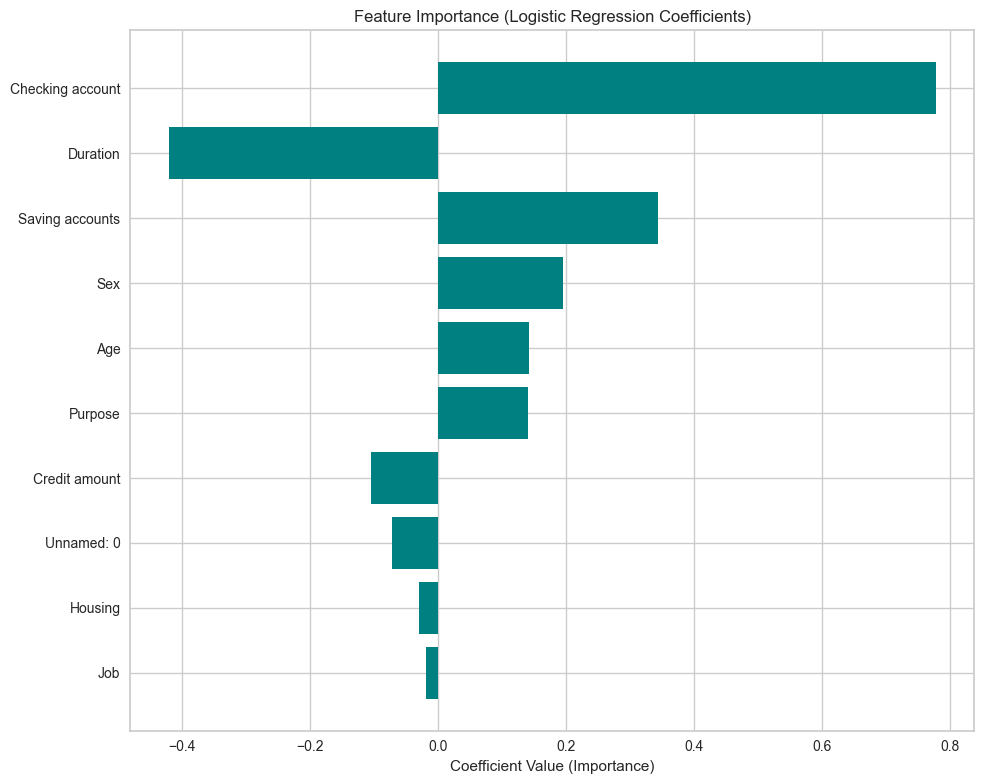

In [4]:

numeric_df = df.select_dtypes(include=np.number)
y = numeric_df['Risk']
numeric_df = numeric_df.drop('Risk',axis=1)

#df = df.drop('column_name', axis=1)


# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# # # Scale features (important for logistic regression!)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Fit Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

# Get feature importances (coefficients)
coefficients = model.coef_[0]
feature_names = numeric_df.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
}).sort_values(by='Importance', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value (Importance)')
plt.gca().invert_yaxis()  # Top importance on top
plt.tight_layout()
plt.show()

This cell generates a scatter matrix plot for a DataFrame df containing numeric data. The scatter plot can be used to visualize the relationships and distributions of numeric variables in a dataset.

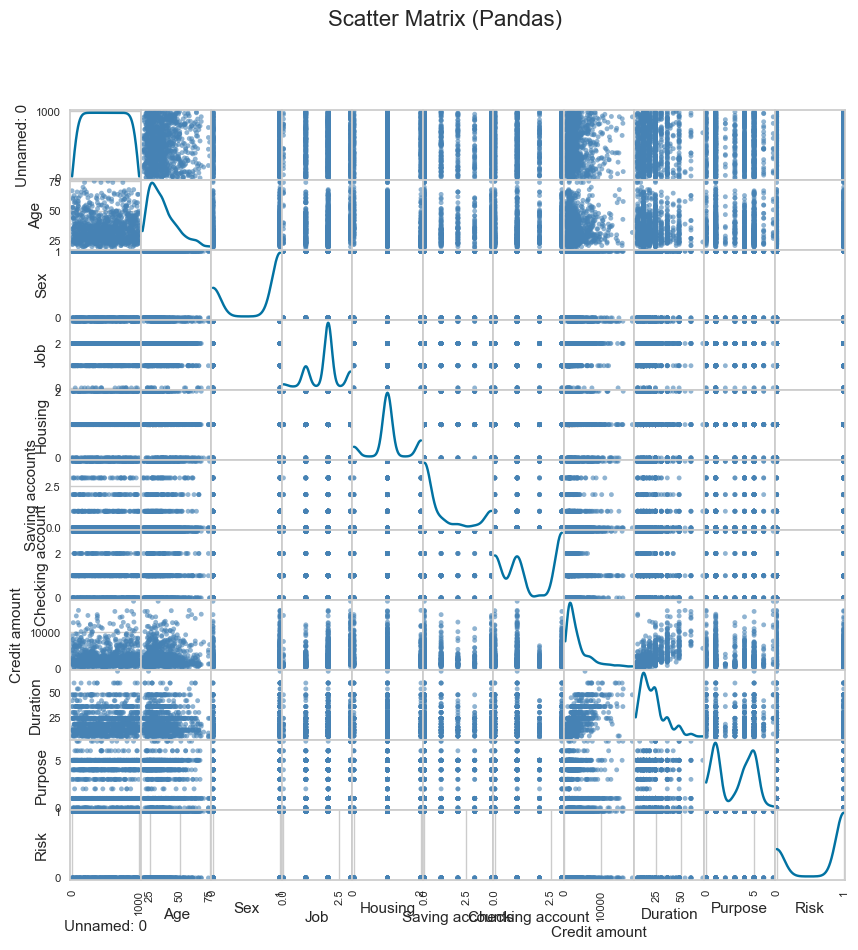

In [5]:
numeric_df = df.select_dtypes(include='number')

# Create scatter matrix
scatter_matrix(numeric_df, figsize=(10, 10), diagonal='kde', color='steelblue', alpha=0.6)
plt.suptitle("Scatter Matrix (Pandas)", fontsize=16)
plt.show()

This cell quickly identify the best model for predicting the target variable by comparing various algorithms using cross-validation and performance metrics, without needing to manually tune or test different models.

In [6]:
numeric_df = df.select_dtypes(include=np.number)
#numeric_df = numeric_df.drop('Risk',axis=1)
numeric_df.info()
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_pca)

# Compute reconstruction error
reconstruction_error = np.linalg.norm(X_scaled - X_reconstructed, axis=1)

# Set threshold
threshold = np.percentile(reconstruction_error, 95)  # Top 5% are outliers
mask = reconstruction_error < threshold

# Filter data
filtered_df = df[mask]
clf1 = setup(
    data=filtered_df,
    target='Risk',
    session_id=123,        # for reproducibility
    verbose=False          # keep the output clean
)
best_model = compare_models()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Unnamed: 0        1000 non-null   int64
 1   Age               1000 non-null   int64
 2   Sex               1000 non-null   int32
 3   Job               1000 non-null   int64
 4   Housing           1000 non-null   int32
 5   Saving accounts   1000 non-null   int32
 6   Checking account  1000 non-null   int32
 7   Credit amount     1000 non-null   int64
 8   Duration          1000 non-null   int64
 9   Purpose           1000 non-null   int32
 10  Risk              1000 non-null   int32
dtypes: int32(6), int64(5)
memory usage: 62.6 KB


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7609,0.7406,0.9125,0.7897,0.8460,0.3194,0.3434,0.0970
ridge,Ridge Classifier,0.7488,0.7388,0.9229,0.7740,0.8416,0.2547,0.2774,0.0140
xgboost,Extreme Gradient Boosting,0.7488,0.7388,0.8771,0.7977,0.8343,0.3152,0.3260,0.3760
qda,Quadratic Discriminant Analysis,0.7456,0.7225,0.8708,0.7971,0.8316,0.3132,0.3215,0.0140
lr,Logistic Regression,0.7442,0.7422,0.9042,0.7783,0.8362,0.2653,0.2818,1.8010
lda,Linear Discriminant Analysis,0.7442,0.7386,0.8979,0.7814,0.8353,0.2728,0.2875,0.0160
lightgbm,Light Gradient Boosting Machine,0.7413,0.7380,0.8646,0.7967,0.8273,0.3061,0.3177,0.2940
gbc,Gradient Boosting Classifier,0.7338,0.7207,0.8771,0.7820,0.8259,0.2644,0.2783,0.0830
ada,Ada Boost Classifier,0.7293,0.7129,0.8688,0.7810,0.8218,0.2614,0.2736,0.0580
nb,Naive Bayes,0.7277,0.7314,0.8583,0.7847,0.8193,0.2687,0.2766,0.0150


In [7]:
# Separate features and target
X = df.iloc[:, :-1]  # all columns except the last
y = df.iloc[:, -1] 

#print(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                        random_state=123, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Predict on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.75
Confusion Matrix:
[[ 23  36]
 [ 14 127]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.39      0.48        59
           1       0.78      0.90      0.84       141

    accuracy                           0.75       200
   macro avg       0.70      0.65      0.66       200
weighted avg       0.73      0.75      0.73       200



In [9]:
target_col = 'Risk'
standard_cols = ['Credit amount', 'Duration','Age']
minmax_cols = [col for col in df.columns if col not in standard_cols + ['Risk', 'Unnamed: 0']]

# Split features and target
X = df.drop(columns=[target_col, 'Unnamed: 0'])
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define column transformer
scaler = ColumnTransformer([
    ('standard', StandardScaler(), standard_cols),
    ('minmax', MinMaxScaler(), minmax_cols)
])

# Create pipeline
pipeline = Pipeline([
    ('scaling', scaler),
    ('logreg', LogisticRegression(max_iter=5000, random_state=123))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)

print("Logistic Regression Accuracy:", score)

Logistic Regression Accuracy: 0.75


In [10]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
score = accuracy_score(y_test, y_pred)

print("Accuracy Score:", score)


Accuracy Score: 0.755


In [11]:
param_grid = {
    'n_estimators': [10, 50, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 10],
}
model = RandomForestClassifier()

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.7537499999999999
Accuracy: 0.75
Confusion Matrix:
[[ 23  36]
 [ 14 127]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.39      0.48        59
           1       0.78      0.90      0.84       141

    accuracy                           0.75       200
   macro avg       0.70      0.65      0.66       200
weighted avg       0.73      0.75      0.73       200



In [12]:

# Columns to apply PowerTransformer to
power_features = ['Credit amount', 'Duration']

# Column transformer to scale selected features
preprocessor = ColumnTransformer(
    transformers=[
        ('power', PowerTransformer(method='yeo-johnson'), power_features)
    ],
    remainder='passthrough'  # Leave the rest of the columns unchanged
)

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100,
        max_features='sqrt',
        random_state=123,
        n_jobs=-1,
        class_weight='balanced'
    ))
])


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.76
Confusion Matrix:
[[ 25  34]
 [ 14 127]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        59
           1       0.79      0.90      0.84       141

    accuracy                           0.76       200
   macro avg       0.71      0.66      0.68       200
weighted avg       0.75      0.76      0.74       200



In [13]:


# 1. Copy the DataFrame
df_fe = df.copy()

# 2. Feature Engineering
df_fe['Credit_per_Month'] = df_fe['Credit amount'] / (df_fe['Duration'] + 1)  # +1 to avoid divide by zero
df_fe['Age_bin'] = pd.cut(df_fe['Age'], bins=[0, 25, 40, 60, 100], labels=[0, 1, 2, 3])

# Convert new categorical feature to int
df_fe['Age_bin'] = df_fe['Age_bin'].astype(int)

# 3. Power Transform specific columns
pt = PowerTransformer()
df_fe[['Credit amount', 'Duration']] = pt.fit_transform(df_fe[['Credit amount', 'Duration']])

# 4. Separate features and target
X = df_fe.drop(columns=['Risk'])  # all except target
y = df_fe['Risk']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. RandomForest with class_weight
model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    random_state=123,
    n_jobs=-1,
    class_weight='balanced'
)

# 7. Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 8. Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.79
Confusion Matrix:
[[ 24  35]
 [  7 134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.41      0.53        59
           1       0.79      0.95      0.86       141

    accuracy                           0.79       200
   macro avg       0.78      0.68      0.70       200
weighted avg       0.79      0.79      0.77       200



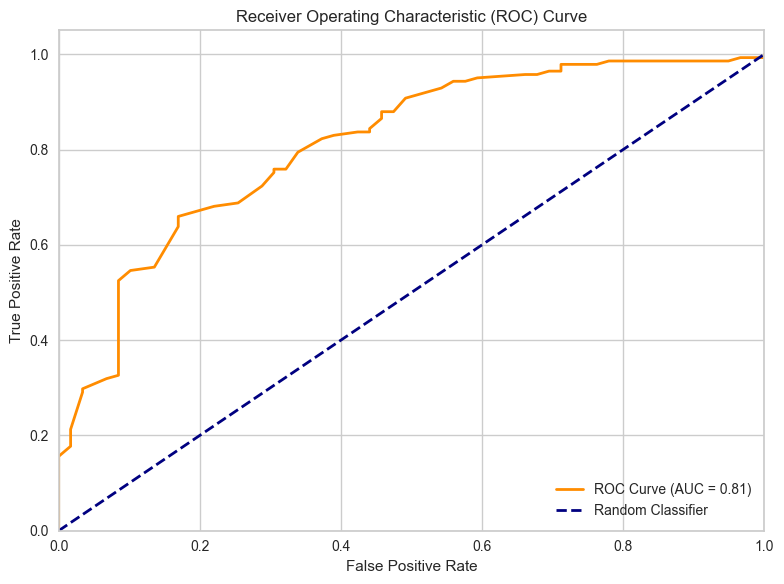

In [14]:
# Predict probabilities for class 1 (positive class)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# 1. Copy the DataFrame
df_fe = df.copy()

# 2. Feature Engineering
df_fe['Credit_per_Month'] = df_fe['Credit amount'] / (df_fe['Duration'] + 1)  # +1 to avoid divide by zero
df_fe['Age_bin'] = pd.cut(df_fe['Age'], bins=[0, 25, 40, 60, 100], labels=[0, 1, 2, 3])

# Convert new categorical feature to int
df_fe['Age_bin'] = df_fe['Age_bin'].astype(int)

# 3. Power Transform specific columns
pt = PowerTransformer()
df_fe[['Credit amount', 'Duration']] = pt.fit_transform(df_fe[['Credit amount', 'Duration']])

# 4. Separate features and target
X = df_fe.drop(columns=['Risk','Job','Housing','Purpose','Sex'])  # all except target
y = df_fe['Risk']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. RandomForest with class_weight
model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    random_state=123,
    n_jobs=-1,
    class_weight='balanced'
)

# 7. Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 8. Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.80
Confusion Matrix:
[[ 29  30]
 [ 10 131]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.49      0.59        59
           1       0.81      0.93      0.87       141

    accuracy                           0.80       200
   macro avg       0.78      0.71      0.73       200
weighted avg       0.79      0.80      0.79       200



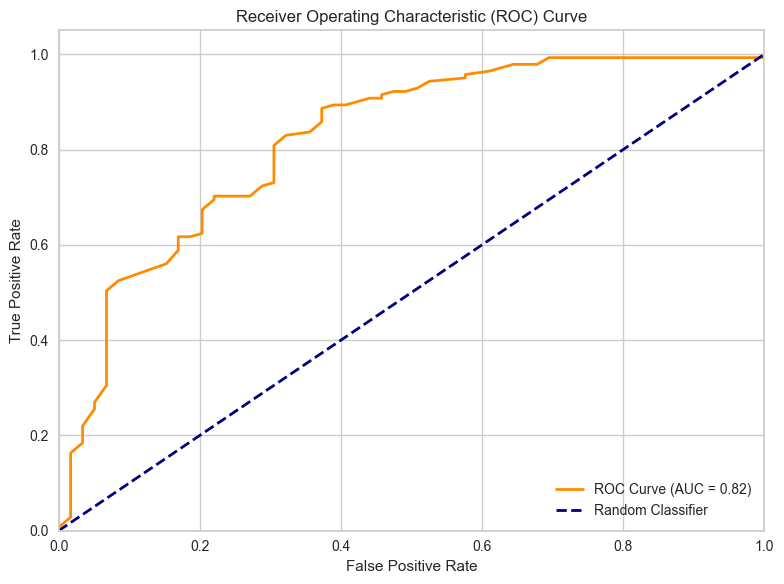

In [16]:
# Predict probabilities for class 1 (positive class)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
